<a href="https://colab.research.google.com/github/jakey1610/MachineLearningL3/blob/master/birdgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [55]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_set = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ]))

#Scan through to get idx
idx = []
for i in range(len(train_set)):
  if train_set[i][1] in [0,2,7]:
    idx.append(i)

sampler = SubsetRandomSampler(idx)
train_loader = torch.utils.data.DataLoader(train_set,
batch_size=8, sampler=sampler)

train_iterator = iter(cycle(train_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')

Files already downloaded and verified
> Size of training dataset 10000


**View some of the test dataset**

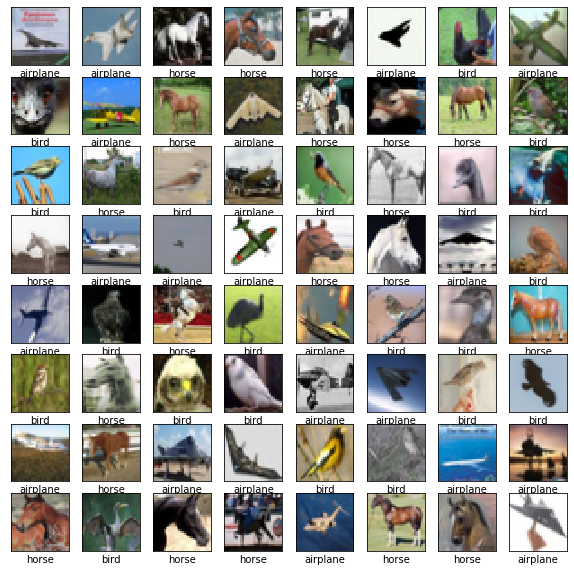

In [56]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_loader.dataset[idx[i]][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_loader.dataset[idx[i]][1]])


**Define the Generator and Discriminator Networks**

In [0]:
class Generator(nn.Module):
    def __init__(self, f=64):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(100, f*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*8, f*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*4, f*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*2, f, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f),
            nn.ReLU(True),
            nn.ConvTranspose2d(f, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            torch.nn.utils.spectral_norm(nn.Conv2d(3, f, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f, f*2, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*2, f*4, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*4, f*8, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*8, 3, 3, 1, 1)),
            nn.Sigmoid()
        )
        

**Initialise the Optimisers**

In [0]:
GN = Generator().to(device)
DN = Discriminator().to(device)
# initialise the optimisers
optimiser_G = torch.optim.Adam(GN.parameters(), lr=0.001, betas=(0.5, 0.999))
optimiser_D = torch.optim.Adam(DN.parameters(), lr=0.001, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()

epoch = 0
liveplot = PlotLosses()

**Training Loops**

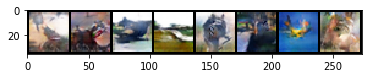

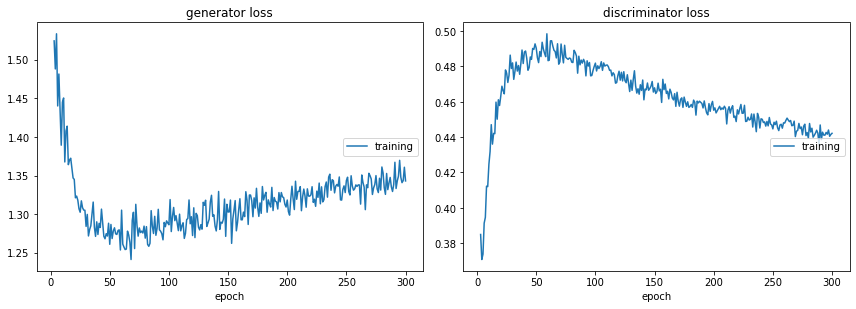

generator loss:
training   (min:    1.241, max:    1.945, cur:    1.343)

discriminator loss:
training   (min:    0.305, max:    0.499, cur:    0.442)


In [60]:
# training loop
while (epoch<300):
    
    # arrays for metrics
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)
    exp_rep = None
    # iterate over some of the train dateset
    for i in range(300):
        # train discriminator 
        for j in range(5):
            x,t = next(train_iterator)
            x,t = x.to(device), t.to(device)
            optimiser_D.zero_grad()
            g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
            l_r = bce_loss(DN.discriminate(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
            l_f = bce_loss(DN.discriminate(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
            try:
              l_e = bce_loss(DN.discriminate(exp_rep.detach()).mean(), torch.zeros(1)[0].to(device))
              loss_d = (l_r + l_f + l_e)/3.0
            except:
              loss_d = (l_r + l_f)/2.0
            loss_d.backward()
            optimiser_D.step()
          
        # train generator
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        optimiser_G.zero_grad()
        g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
        exp_rep = g
        loss_g = bce_loss(DN.discriminate(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
        loss_g.backward()
        optimiser_G.step()

        gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
        dis_loss_arr = np.append(dis_loss_arr, loss_d.item())

    # plot some examples
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    liveplot.update({
        'generator loss': gen_loss_arr.mean(),
        'discriminator loss': dis_loss_arr.mean()
    })
    liveplot.draw()
    epoch = epoch+1

In [0]:
g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
img = g
save_image(img, 'img.png')


**Save the trained model**

In [0]:
#Save the trained model
PATH_DN = './DN_PEG_3_cifar_net.pth'
torch.save(DN.state_dict(), PATH_DN)
PATH_GN = './GN_PEG_cifar_net.pth'
torch.save(GN.state_dict(), PATH_GN)